In [1]:
# MST Value Factor size of nodes correlation on production. 

In [52]:
import datetime
import networkx as nx
import pandas as pd
import ancil_graph
import ancil_load
import math

ancil_graph=reload(ancil_graph)

# Read Trading prices info for historical state
df_state=pd.read_csv("/mnt/y/Data/Electricity/Average_prices/df_all_VIC_PUBLIC_DVD_TRADING_PRICE.csv",index_col="SETTLEMENTDATE")
df_state=df_state.set_index(pd.DatetimeIndex(df_state.index))
# Neccesary to start at 1am rather than 30
df_state=df_state.iloc[1::2,:]

# subset stations  by wind in Vic
# Fuel source
Gen_info=pd.read_excel("/mnt/y/Code/Dev/graph/MacBank/NEM Registration and Exemption List.xls",sheet_name="Generators and Scheduled Loads")
Gen_info_wind=Gen_info[Gen_info["Fuel Source - Primary"]=="Wind"]
intersect=list(set(df_state.columns) & set(Gen_info_wind.loc[:,"DUID"]))
price=df_state.loc[:,"VIC"]

df_state=df_state.drop(["VIC"],axis=1)

# The production for project pipeline for WIND
df_all = pd.read_csv("/mnt/y/Data/Power/ECMWF/lillypond/future_wind.csv",index_col="time")
df_all.index=pd.DatetimeIndex(df_all.index)
df_all=df_all.drop("Unnamed: 0",axis=1)
df_all=df_all.iloc[1:,:]

In [13]:
df_all.index

DatetimeIndex(['2008-01-01 01:00:00', '2008-01-01 02:00:00',
               '2008-01-01 03:00:00', '2008-01-01 04:00:00',
               '2008-01-01 05:00:00', '2008-01-01 06:00:00',
               '2008-01-01 07:00:00', '2008-01-01 08:00:00',
               '2008-01-01 09:00:00', '2008-01-01 10:00:00',
               ...
               '2017-12-31 14:00:00', '2017-12-31 15:00:00',
               '2017-12-31 16:00:00', '2017-12-31 17:00:00',
               '2017-12-31 18:00:00', '2017-12-31 19:00:00',
               '2017-12-31 20:00:00', '2017-12-31 21:00:00',
               '2017-12-31 22:00:00', '2017-12-31 23:00:00'],
              dtype='datetime64[ns]', name=u'time', length=87671, freq=None)

In [14]:
df_state.index

DatetimeIndex(['2013-01-01 01:00:00', '2013-01-01 02:00:00',
               '2013-01-01 03:00:00', '2013-01-01 04:00:00',
               '2013-01-01 05:00:00', '2013-01-01 06:00:00',
               '2013-01-01 07:00:00', '2013-01-01 08:00:00',
               '2013-01-01 09:00:00', '2013-01-01 10:00:00',
               ...
               '2017-12-31 15:00:00', '2017-12-31 16:00:00',
               '2017-12-31 17:00:00', '2017-12-31 18:00:00',
               '2017-12-31 19:00:00', '2017-12-31 20:00:00',
               '2017-12-31 21:00:00', '2017-12-31 22:00:00',
               '2017-12-31 23:00:00', '2018-01-01 00:00:00'],
              dtype='datetime64[ns]', name=u'SETTLEMENTDATE', length=43992, freq=None)

In [16]:
price.index

DatetimeIndex(['2013-01-01 01:00:00', '2013-01-01 02:00:00',
               '2013-01-01 03:00:00', '2013-01-01 04:00:00',
               '2013-01-01 05:00:00', '2013-01-01 06:00:00',
               '2013-01-01 07:00:00', '2013-01-01 08:00:00',
               '2013-01-01 09:00:00', '2013-01-01 10:00:00',
               ...
               '2017-12-31 15:00:00', '2017-12-31 16:00:00',
               '2017-12-31 17:00:00', '2017-12-31 18:00:00',
               '2017-12-31 19:00:00', '2017-12-31 20:00:00',
               '2017-12-31 21:00:00', '2017-12-31 22:00:00',
               '2017-12-31 23:00:00', '2018-01-01 00:00:00'],
              dtype='datetime64[ns]', name=u'SETTLEMENTDATE', length=43992, freq=None)

In [56]:
price_future

,$/MW
2019-01-01 00:30:00,73.542795
2019-01-01 01:00:00,69.589516
2019-01-01 01:30:00,57.969934
2019-01-01 02:00:00,55.600752
2019-01-01 02:30:00,53.382900
2019-01-01 03:00:00,52.457731
2019-01-01 03:30:00,53.754402
2019-01-01 04:00:00,52.167504
2019-01-01 04:30:00,51.530409
2019-01-01 05:00:00,52.419031


In [43]:
# future price

In [55]:
# Future Price based on chronological
import datetime as dt
future=pd.read_excel("/mnt/y/Data/Electricity/future/Half-hour output prices.xlsx",skiprows=2)

# To store all future prices
price_future=pd.DataFrame()
start=dt.datetime(2019,1,1,0,30)


for year in range(2019,2030):
    price_year=pd.DataFrame()
    price_year=pd.DataFrame(future[year])
    price_year=price_year[price_year!=0]
    price_year=price_year.dropna()
    index=pd.date_range(dt.datetime(year,1,1,0,30),periods=len(price_year),freq='30min')
    price_year.index=index
    #price_future=price_future.append(price_year)
    price_year.columns=["$/MW"]
    price_future=pd.concat([price_future,price_year],axis=0)
price_fu

hi


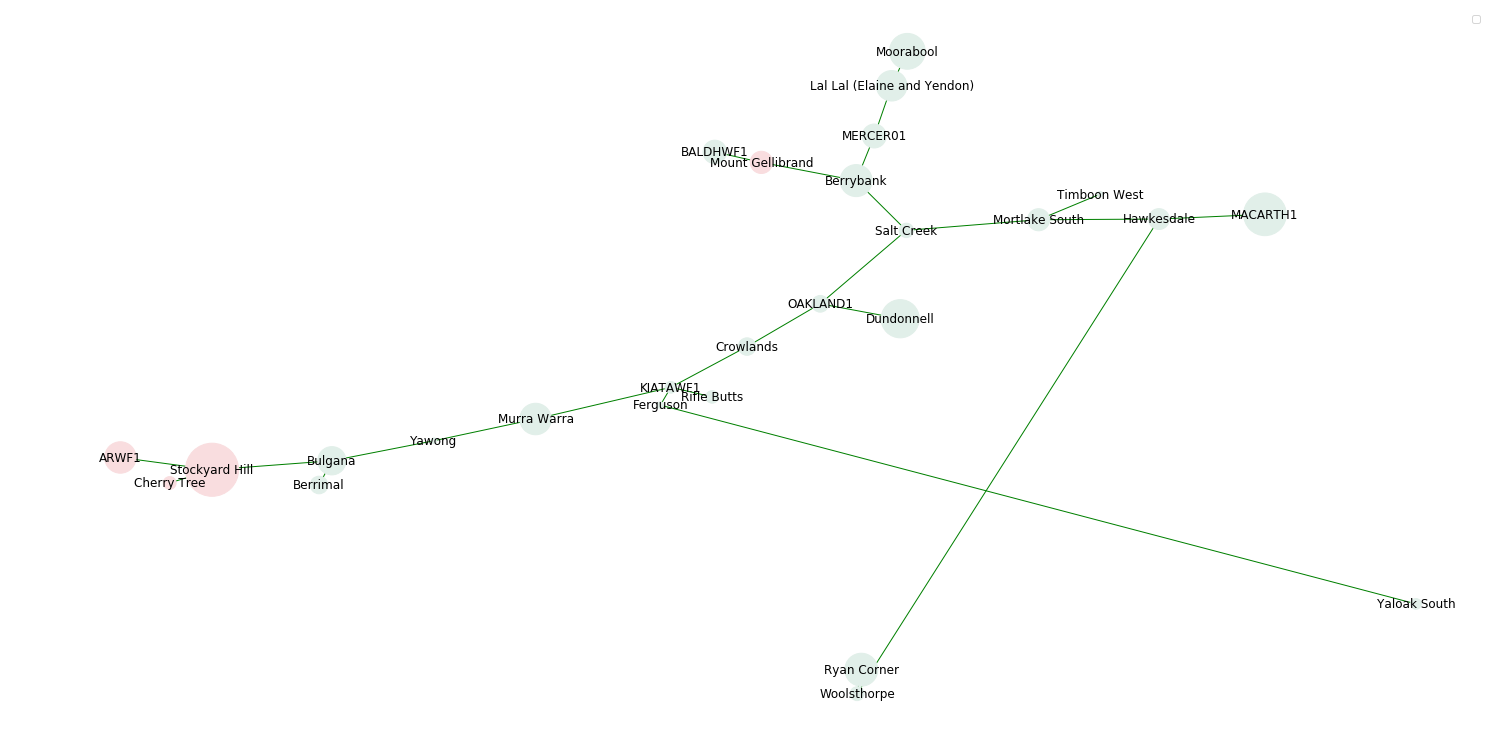

In [53]:
# what is time step month,season,year?

df_central=pd.DataFrame()
#for year in range(2013,2018):

tstart=datetime.datetime(2013,1,1,0,1)
tstart2=datetime.datetime(2017,12,30,0,30)

# subset on time, calculate the three df's (one is revenue)

df_delta = df_all.loc[tstart:tstart2]
df_price=df_delta.mul(price.loc[df_delta.index],axis=0)
df_state=df_state.loc[df_delta.index]

# # Dealing with top 10%

#df_delta,df_price,df_state=ancil_graph.graph_quantile(df_delta,df_all,price,df_state,.999)

#G=ancil_graph.makeG(df_delta,df_price,df_state1,"yearly_power/MaximumSpanningTree/nofrills_graph/case_studies/corr_rev_color_VF_size_rev_extreme{0}AUD{1}".format(price.loc[time],time),price=price.loc[df_delta.index])
G=ancil_graph.makeG(df_delta,df_price,df_state,price.loc[df_delta.index],"/mnt/y/Code/Analysis/graph/Graph_figures/Vic_project/total/corr_prod_color_VF_size_prod_2013_2017")
# INLCUDE DEMAND

#demand_SA=demand(tstart)
#demand_SA=demand_SA["SA1"]

# Build dataframe of graph
for g in G.nodes:
    #print(g)
    df_ind=pd.DataFrame()
    Centrality_metric=["CBN1","CBN2","Degree","Degree_centrality"]#"Betweeness","Eigencentrality","load","katz","Pagerank","Closeness"]
    for cent in Centrality_metric:
        df_ind[cent]=pd.Series(nx.get_node_attributes(G,cent)[g])
    df_ind["node"]=pd.Series(g)
    #df_ind["gentype"]=pd.Series(Gen_info[Gen_info["DUID"]==g]["Fuel Source - Primary"]).iloc[0]
    #df_ind["state"]=pd.Series(Gen_info[Gen_info["DUID"]==g]["Region"]).iloc[0]#TODO
    df_ind["time"]=tstart
    #df_ind["time"]=time
    #df_ind["demand"] = pd.Series(demand_SA.sum(axis=0)/10**6)

    #df_ind["Virtual_revenue"]=df_price[g].corr(df_state.mul(price.loc[df_state.index],axis=0))
    #df_ind["Virtual_production"]=df_delta[g].corr(df_state.sum(axis=0))
    #df_ind["Virtual_RRP"]=df_delta[g].corr(price.loc[df_delta.index])
    df_ind["ValueFactor"]=ancil_graph.valuefactor(df_delta,df_state,g,price)
    df_ind["Generation"]=df_delta[g].sum()

    #print(df_ind)
    df_central=df_central.append(df_ind)
#tstart=tstart+datetime.timedelta("1year")

#test=df_central.groupby(["node","time"]).mean()
#df_central_stack=test.unstack(level=[0])

In [41]:
df_central

,CBN1,CBN2,Degree,Degree_centrality,node,time,ValueFactor,Generation
0,0.966052,0.012037,3,0.115385,Salt Creek,2013-01-01 00:01:00,93.256014,7.814439e+05
0,0.970371,0.033745,2,0.076923,MERCER01,2013-01-01 00:01:00,93.783029,2.133989e+06
0,0.981599,0.080848,1,0.038462,Moorabool,2013-01-01 00:01:00,92.806455,4.832112e+06
0,0.979776,0.061472,1,0.038462,ARWF1,2013-01-01 00:01:00,92.198635,3.748822e+06
0,0.914899,0.016910,1,0.038462,Berrimal,2013-01-01 00:01:00,93.991846,1.152358e+06
0,0.985529,0.118325,1,0.038462,MACARTH1,2013-01-01 00:01:00,93.547773,6.806725e+06
0,0.983989,0.056844,2,0.076923,Lal Lal (Elaine and Yendon),2013-01-01 00:01:00,93.615665,3.467963e+06
0,0.956631,0.061860,3,0.115385,Berrybank,2013-01-01 00:01:00,93.061275,3.856796e+06
0,1.000000,0.006739,1,0.038462,Yaloak South,2013-01-01 00:01:00,94.805367,4.250797e+05
0,0.981156,0.066856,1,0.038462,Ryan Corner,2013-01-01 00:01:00,93.628394,4.050875e+06


In [36]:
import numpy as np
np.sort(np.array(list(G.nodes())))

array(['ARWF1', 'BALDHWF1', 'Berrimal', 'Berrybank', 'Bulgana',
       'Cherry Tree', 'Crowlands', 'Dundonnell', 'Ferguson', 'Hawkesdale',
       'KIATAWF1', 'Lal Lal (Elaine and Yendon)', 'MACARTH1', 'MERCER01',
       'Moorabool', 'Mortlake South', 'Mount Gellibrand', 'Murra Warra',
       'OAKLAND1', 'Rifle Butts', 'Ryan Corner', 'Salt Creek',
       'Stockyard Hill', 'Timboon West', 'Woolsthorpe', 'Yaloak South',
       'Yawong'], dtype='|S27')

In [18]:
pd.read_csv("/mnt/y/concepts/LGA_area/helpful_conversion_chart.csv")

,Unnamed: 0,LGA2,Project
0,0,Wimmera,Berrimal
1,1,Great South Coast,Berrybank
2,2,Wimmera,Bulgana
3,3,Goulburn,Cherry Tree
4,4,Wimmera,Crowlands
5,5,Great South Coast,Dundonnell
6,6,Great South Coast,Ferguson
7,7,Great South Coast,Hawkesdale
8,8,Central Highlands,Lal Lal (Elaine and Yendon)
9,9,Central Highlands,Moorabool


In [19]:
    lga_area=pd.read_csv("/mnt/y/concepts/LGA_area/lga_1_3_complete.csv")
    lga_area.index=lga_area["LGA3"]

In [20]:
lga_area

,LGA3,LGA2,LGA1
LGA3,,,
ARARAT RURAL CITY,ARARAT RURAL CITY,Central Highlands,Central Vic
CAMPASPE SHIRE,CAMPASPE SHIRE,Loddon,Central Vic
CENTRAL GOLDFIELDS SHIRE,CENTRAL GOLDFIELDS SHIRE,Loddon,Central Vic
GREATER BENDIGO CITY,GREATER BENDIGO CITY,Loddon,Central Vic
HEPBURN SHIRE,HEPBURN SHIRE,Central Highlands,Central Vic
LODDON SHIRE,LODDON SHIRE,Loddon,Central Vic
MACEDON RANGES SHIRE,MACEDON RANGES SHIRE,Loddon,Central Vic
MITCHELL SHIRE,MITCHELL SHIRE,Goulburn,Central Vic
MOUNT ALEXANDER SHIRE,MOUNT ALEXANDER SHIRE,Loddon,Central Vic
